In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as sa
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector=inspect(engine)
columns=inspector.get_columns("Measurement")
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
engine.execute("Select * from Measurement limit 10").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [14]:
inspector=inspect(engine)
columns=inspector.get_columns("Station")
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [84]:
engine.execute("Select * from Station").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [148]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)
# Perform a query to retrieve the data and precipitation scores
query_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(query_data,columns=["date","precipitation"]).sort_values("date")
df.set_index("date",inplace=True)
df.head()
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

2016-08-23


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [160]:
session.query(Measurement.date,func.max(Measurement.prcp)).filter(Measurement.date>=query_date).all()

[('2016-09-14', 6.7)]

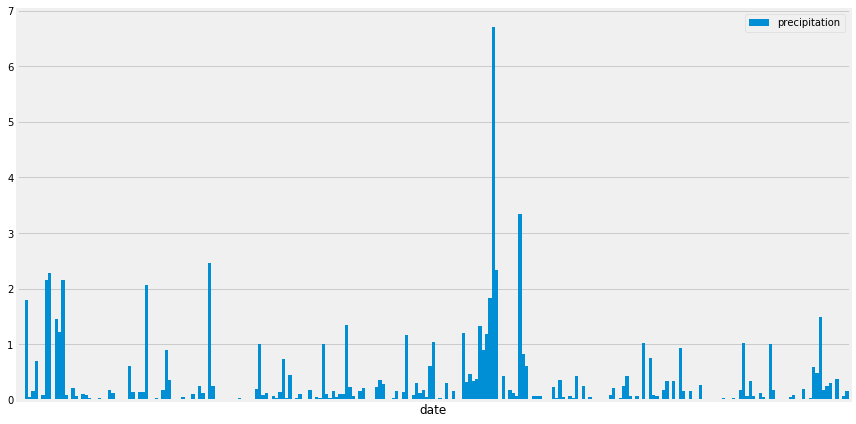

<Figure size 432x288 with 0 Axes>

In [213]:
df.loc["2016-08-01":"2016-09-30"].plot(kind="bar",figsize=(12,6),align="edge",grid=True,width=1)
plt.xticks([])
plt.tight_layout()
plt.show()
plt.savefig("precipitation.png")

![precipitation](Images/precipitation.png)

In [150]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary=pd.DataFrame({"count":df.count(),"mean":df.mean(),"std":df.std(),"min":df.min(),"25%":df.quantile(0.25),
                     "50%":df.quantile(0.5),"75%":df.quantile(0.75),"max":df.max()})
summary=summary.transpose()
summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [57]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).distinct().count()

9

In [71]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [72]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station=="USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

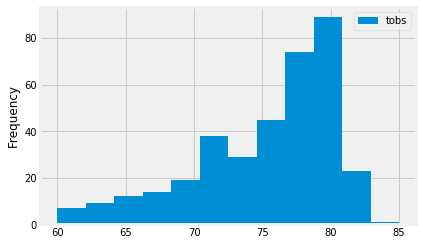

<Figure size 432x288 with 0 Axes>

In [214]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station,func.max(Measurement.tobs)).all()
tobresults=session.query(Measurement.tobs).filter(Measurement.station=="USC00519397").filter(Measurement.date>=query_date).all()
tobdf=pd.DataFrame(tobresults)
tobdf.plot(kind="hist",bins=12,range=(60,85))
plt.show()
plt.savefig("tobs.png")

![precipitation](Images/station-histogram.png)

In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [243]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date=dt.date(2018, 3, 5) - dt.timedelta(days=365)
end_date=dt.date(2018, 3, 10) - dt.timedelta(days=365)
print(calc_temps(start_date,end_date))
calresult=calc_temps(start_date,end_date)
height=calresult[0][1]
yerr=calresult[0][2]-calresult[0][0]

[(62.0, 69.08108108108108, 76.0)]


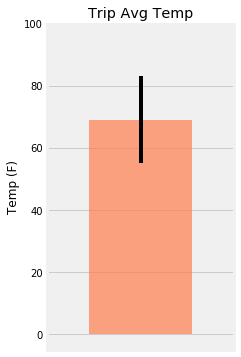

<Figure size 432x288 with 0 Axes>

In [244]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,6))
plt.bar(1,height,yerr=yerr,color="coral",alpha=0.7,width=1.1)
plt.xlim(0,2)
plt.ylim(-5,100)
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show()
plt.savefig("trip_avg_temp.png")

In [245]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall=session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,\
                       func.sum(Measurement.prcp)).\
filter(Measurement.station==Station.station).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_df=pd.DataFrame(rainfall,columns=["station","name","latitude","longitude","elevation","precipitation"])
rainfall_df

,station,name,latitude,longitude,elevation,precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.54
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.12
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.63
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.35
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


## Optional Challenge Assignment

In [246]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [268]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
start = dt.datetime.strptime("2018-03-05", "%Y-%m-%d")
end = dt.datetime.strptime("2018-03-10", "%Y-%m-%d")
dates=[]
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]
for date in date_generated:
    dates.append(date.strftime("%m-%d"))
for day in dates:
    print(daily_normals(day))
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

[[(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)],
 [(60.0, 69.17241379310344, 78.0)],
 [(59.0, 68.72413793103448, 78.0)],
 [(57.0, 68.56140350877193, 75.0)]]

In [278]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_date=[]
for date in date_generated:
    trip_date.append(date.strftime("%Y-%m-%d"))
daily=[]
for day in dates:
    daily_normal={}
    daily_normal["tmin"]=daily_normals(day)[0][0]
    daily_normal["tavg"]=daily_normals(day)[0][1]
    daily_normal["tmax"]=daily_normals(day)[0][2]
    daily.append(daily_normal)
daily_df=pd.DataFrame(daily)
daily_df["date"]=trip_date
daily_df.set_index("date",inplace=True)
daily_df

,tavg,tmax,tmin
date,,,
2018-03-05,67.890909,76.0,60.0
2018-03-06,69.203390,76.0,60.0
2018-03-07,69.172414,78.0,60.0
2018-03-08,68.724138,78.0,59.0
2018-03-09,68.561404,75.0,57.0


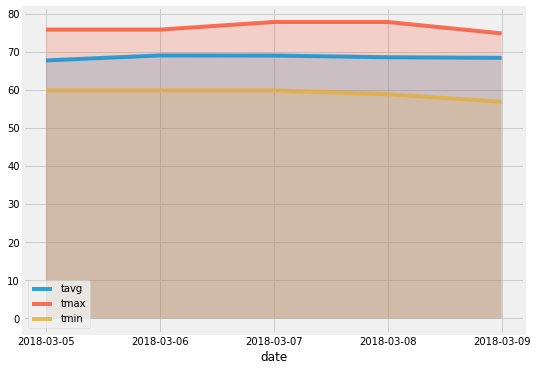

<Figure size 432x288 with 0 Axes>

In [293]:
# Plot the daily normals as an area plot with `stacked=False`
daily_df.plot(kind="line",stacked=False,alpha=0.8,figsize=(8,6))
plt.fill_between(daily_df.index,daily_df["tavg"],alpha=0.2)
plt.fill_between(daily_df.index,daily_df["tmax"],alpha=0.2)
plt.fill_between(daily_df.index,daily_df["tmin"],alpha=0.2)
xlocation=[x for x in daily_df.index]
plt.xticks(xlocation,daily_df.index)
plt.show()
plt.savefig("daily_normal.png")